In [10]:
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2 as ps
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", message="pandas only supports SQLAlchemy connectable")

In [11]:
conn = ps.connect(dbname="capstonedb",
                  user="postgres",
                  password="12345",
                  port = "5432")

In [12]:
# 1- ÜRÜN SATIŞ ANALİZİ - İNDİRİM MİKTARLARINA GÖRE

In [13]:
sql = """with country_sales_disc_rates as(
select 
    o.ship_country as country,
	od.discount as discount,
	count(o.order_id) as order_count,
    round(sum(od.unit_price * od.quantity)::numeric, 2) as total_sales 
from
    orders as o
inner join
    order_details as od on o.order_id = od.order_id
group by 
    1,2
),
segmented_discounts as(
select
	country,
	case
		when discount = 0 then '%0 discount'
		when discount <= 0.1 then '%0-10 discount rate'
		when discount <= 0.20 then '%10-20 discount rate'
		when discount <= 0.3 then '%20-25 discount rate'
	end as discount_segments,
	order_count,
	total_sales
from
	country_sales_disc_rates
order by 1,2
),
discount_segmented_totals as(
select
	country,
	discount_segments,
	sum(order_count) as total_orders,
	sum(total_sales) as total_sales
from
	segmented_discounts
group by
	1,2
order by
	1,2
)
select
	discount_segments,
	sum(total_orders) as total_orders,
	sum(total_sales) as total_sales
from
	discount_segmented_totals
group by
	1
"""

In [14]:
df = sqlio.read_sql_query(sql,conn)
df.head()

,discount_segments,total_orders,total_sales
0,%10-20 discount rate,330.0,204614.15
1,%0-10 discount rate,193.0,155751.36
2,%0 discount,1317.0,750698.61
3,%20-25 discount rate,315.0,243394.47


In [15]:
df.shape

(4, 3)

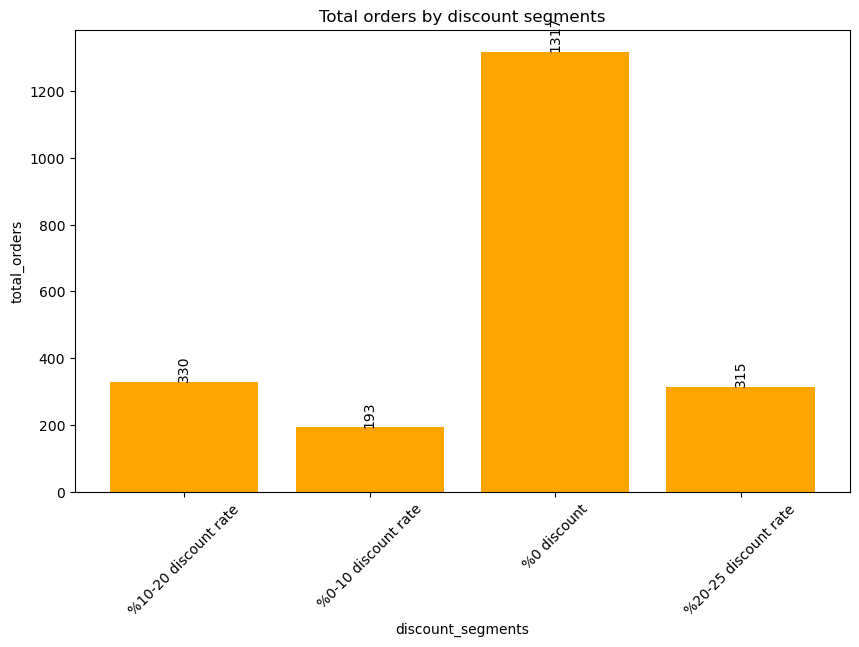

In [16]:
plt.figure(figsize=(10, 6))
bars = plt.bar(df['discount_segments'], df['total_orders'], color='orange')
plt.xlabel('discount_segments')
plt.ylabel('total_orders')
plt.title('Total orders by discount segments')
plt.xticks(rotation=45)


for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(int(bar.get_height())), 
             ha='center', va='bottom', fontsize=10, rotation=90)

plt.show()

In [17]:
## segmnete edilen indirim miktarlarının satış adetleri ile olan toplam farkların görülebileceği bir bar chart yaratılıyor. ##
## Bu graifte indirim düzeylerinin satışlara katkısı olduğu gözlemleniyor. ##
## %0 indirim segmentinde olan satışların sayısı yüksek olsa bile %10 ile %25 arasında olan indirimlerin satışa katkısı olduğu gözlemleniyor. ##

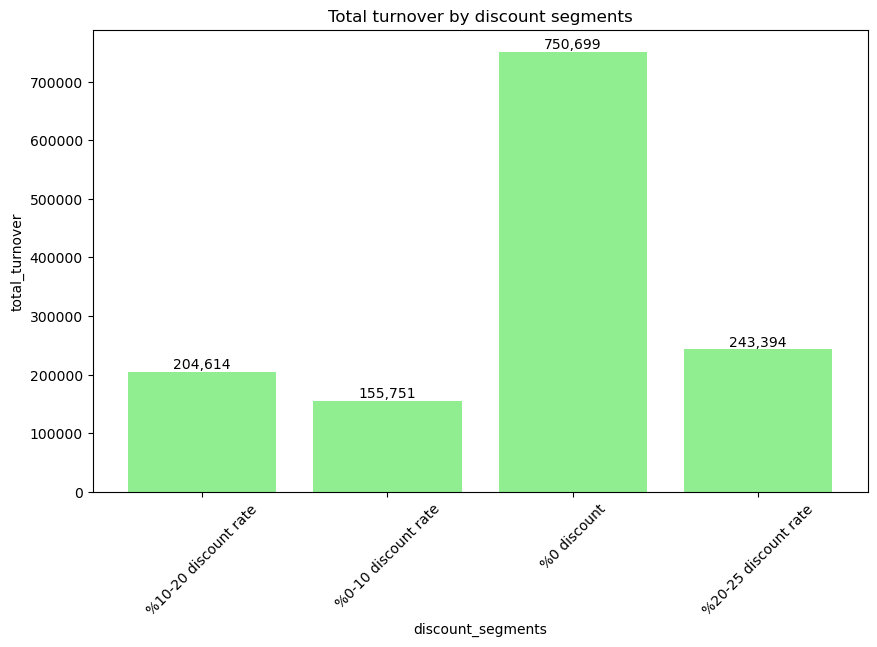

In [18]:
plt.figure(figsize=(10, 6))
bars = plt.bar(df['discount_segments'], df['total_sales'], color='lightgreen')
plt.xlabel('discount_segments')
plt.ylabel('total_turnover')
plt.title('Total turnover by discount segments')
plt.xticks(rotation=45)


for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, 
             f'{bar.get_height():,.0f}',
             ha='center', va='bottom', fontsize=10)

plt.show()

In [19]:
# Gelir analizi yapıldı
# %0 olan ürünlerde satışın hemen hemen genel satışa göre ½50 sini kapladığı görüldü. 
# fakat ½10-#25 arasında olan indirim miktarının bu indirimisiz olan kesime yakınolduğu görüldü.
# fiyatlara göre satışların indirim oranlarının düşürülmesi veya yükseltilmesi imkanı varsa aksiyon alınabilir.

In [20]:
# 2- ÜRÜN - FİYAT SEGMENTİNE GÖRE SATIŞ ANALİZİ

In [21]:
sql2 = """with price_segments as (
        select
			product_id,
			product_name,
            unit_price,
            case when unit_price < 30 then 'Low price segment "<30"'
					when unit_price < 75 then 'Medium price segment "<70"'
					when unit_price < 100 then 'High price segment "<100"'
					else 'Luxury price segment ">100"'
				end price_segments	
          FROM products
),
order_quantities as (
	select
		product_id,
		sum(quantity) as total_quantity_sold
	from
		order_details
	group by
		1
)
  select 
      product_name,
      unit_price,
      price_segments,
	  total_quantity_sold,
      count(product_name) over (partition by price_segments) as segment_product_count
  from 
	  price_segments as ps
  inner join
  	  order_quantities as oq on ps.product_id = oq.product_id
    """

In [22]:
df2 = sqlio.read_sql_query(sql2,conn)
df2.head()

,product_name,unit_price,price_segments,total_quantity_sold,segment_product_count
0,Sir Rodney's Marmalade,81.00,"High price segment ""<100""",313,2
1,Mishi Kobe Niku,97.00,"High price segment ""<100""",95,2
2,Aniseed Syrup,10.00,"Low price segment ""<30""",328,52
3,Chef Anton's Cajun Seasoning,22.00,"Low price segment ""<30""",453,52
4,Chef Anton's Gumbo Mix,21.35,"Low price segment ""<30""",298,52


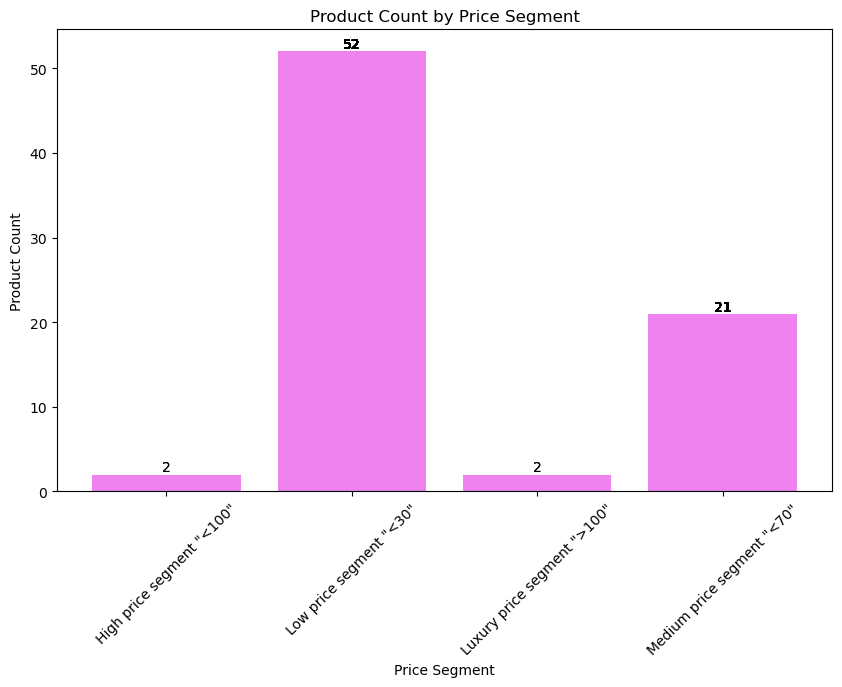

In [23]:
plt.figure(figsize=(10, 6))
bars = plt.bar(df2['price_segments'], df2['segment_product_count'], color='violet')
plt.xlabel('Price Segment')
plt.ylabel('Product Count')
plt.title('Product Count by Price Segment')
plt.xticks(rotation=45)


for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(int(bar.get_height())), 
             ha='center', va='bottom', fontsize=10, rotation=0)

plt.show()

In [24]:
## satılmış ürünlerin bugüne kdar yoğunlukla düşük fiyat segmentinde olduğu görülüyor 
## ortanca fiyat segmentinde ki ürünlerin satış miktarında ek ürünler ve ek tedarikçiler ile eklemeler yapılabilir.

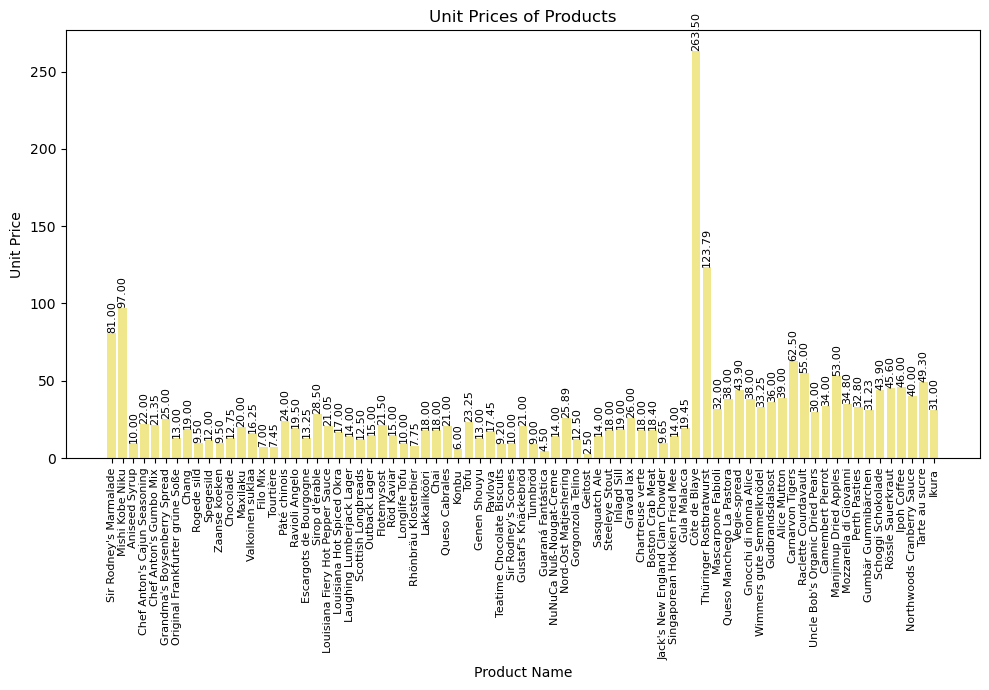

In [25]:
plt.figure(figsize=(10, 7))
bars = plt.bar(df2['product_name'], df2['unit_price'], color='khaki')
plt.xlabel('Product Name')
plt.ylabel('Unit Price')
plt.title('Unit Prices of Products')
plt.xticks(rotation=90, fontsize=8)  

for bar, price in zip(bars, df2['unit_price']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{price:.2f}', 
             ha='center', va='bottom', fontsize=8, rotation=90, color='black')

plt.tight_layout()  
plt.show()

In [26]:
## ürün isimlerine göre yapılan fiyat karşılaştırmasında genelde fiyatların birbirine yakın olduğu gözleniyor
## daha önce yapılmış segmente analizinde de görüldüğü yüksek fiyat segmentlerinde toplamda 4 ürün gözlendi.  

In [27]:
correlation = df2['unit_price'].corr(df2['total_quantity_sold'])
print('Correlation', correlation)

Correlation -0.03615694734981913


C:\Users\MEHMET\AppData\Local\Temp\ipykernel_5320\3794934934.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df2['unit_price'], df2['total_quantity_sold'], cmap='viridis', s=100, alpha=0.8)


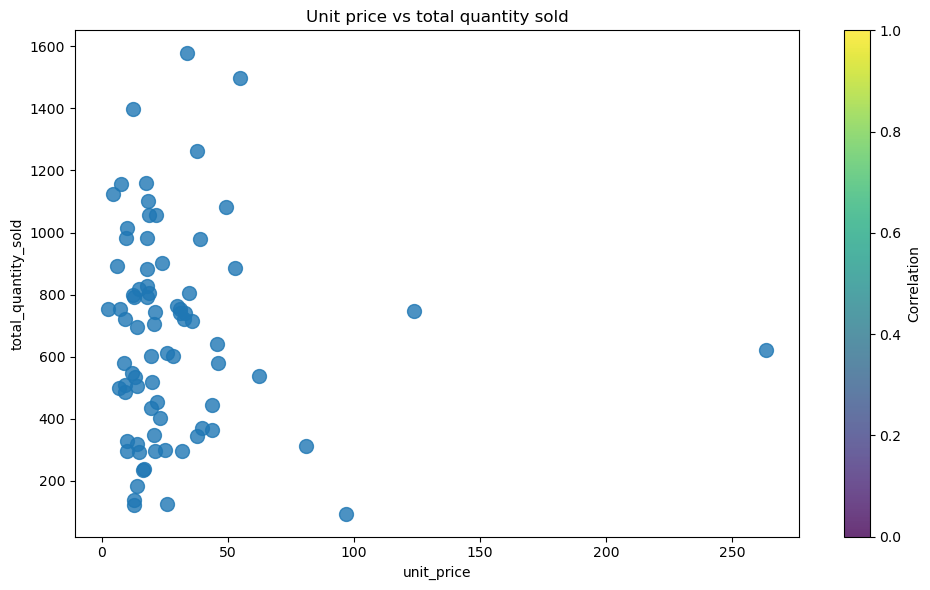

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(df2['unit_price'], df2['total_quantity_sold'], cmap='viridis', s=100, alpha=0.8)
plt.xlabel('unit_price')
plt.ylabel('total_quantity_sold')
plt.title('Unit price vs total quantity sold')
plt.colorbar(label='Correlation')
plt.tight_layout()
plt.show()

In [29]:
##Bu korelasyon değeri, unit_price ile total_quantity_sold arasında zayıf bir negatif ilişki olduğunu gösteriyor.
##Yani, bir ürünün birim fiyatı arttıkça, genellikle satılan toplam miktar azalır. 
##Ancak bu ilişki çok zayıf olduğu için istatistiksel olarak anlamlı bir ilişki olarak kabul edilemez. 
##Yani, bir ürünün fiyatı ile satış miktarı arasında tutarlı bir ilişki olduğunu söylemek doğru olmayabilir.
##Ürün segmentleri arasında büyük farklılıkların olması product / ürün yönetimi içinde çeşitliliğe, 
##veya daha niş hale gelip gelişim kanallarına odaklanılması gerekiyor.
##ürün çeşitlendirilmesi öneriliyor.